In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

In [2]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [3]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [4]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [5]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

In [6]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [7]:
height = pd.read_excel('gc_altitude.xlsx')

In [8]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [9]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [10]:
for ds in [ds_emispulse, ds_emisbase, ds_emis2x]:
    utils.combine_BC(ds)

In [11]:
def calc_δc_δt(ds_delta, ds_base, conc_species):
    ds_delta['conc_dif'] = (utils.global_w_mean(ds_delta, conc_species)- 
                            utils.global_w_mean(ds_base, conc_species))
    δc_δt = ds_delta['conc_dif'].diff('time')
    return(δc_δt)


In [12]:
f = (utils.global_w_mean(ds_emis2x, 'EmisBC_Total') - utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) 
G = calc_δc_δt(ds_delta, ds_base, 'AerMassBC')
G = G.assign_coords(time = np.arange(0,len(G['time'])))
f0 = (utils.global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)


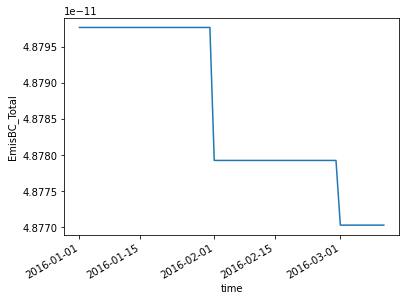

In [13]:
(utils.global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total')).plot()

fig, ax = plt.subplots()
G.plot()
plt.ylabel('GLobal Average Response', fontsize = 16)
plt.xlabel('Time', fontsize = 16)

fig, ax = plt.subplots()
f.plot()


for t in np.arange(0,15):
    fig,ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('b) Difference', fontsize = 16)
    (ds_delta - ds_base)['AerMassBC'].isel(lev = 0, time = t).plot(ax = ax, vmin = 0, vmax = 2)
    plt.savefig(f'video_images/{t}_vid.png', bbox_inches = 'tight')

In [15]:
Ndt = 15
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [16]:
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)


In [17]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0, ds_output = False)
        

NameError: name 'C_df' is not defined

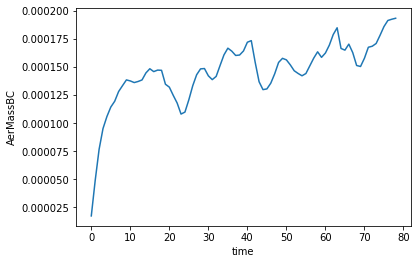

In [14]:
(utils.global_w_mean(ds_conc2x, 'AerMassBC') - utils.global_w_mean(ds_base, 'AerMassBC')).assign_coords(time = np.arange(0,len(ds_base['time']))).plot(label = 'GEOS Chem')
#((C_df.sum(axis = 1)).to_xarray().rename({'index':'time'})).plot(marker = 'o')
plt.plot(C_df.sum(axis = 1), label = 'Greens Functions');
plt.legend()
plt.ylabel('Black Carbon Concentration', fontsize = 16)
plt.xlim(0,30)

<Figure size 432x288 with 0 Axes>

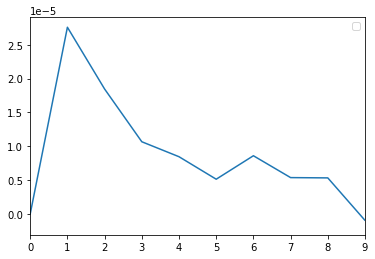

<Figure size 432x288 with 0 Axes>

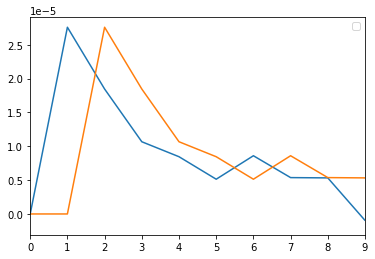

<Figure size 432x288 with 0 Axes>

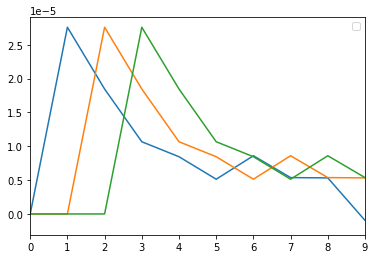

<Figure size 432x288 with 0 Axes>

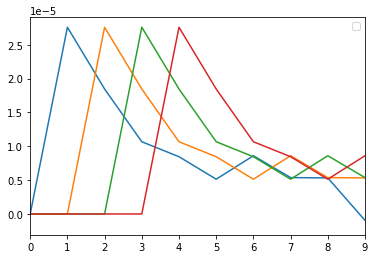

<Figure size 432x288 with 0 Axes>

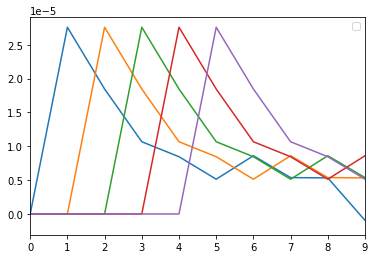

<Figure size 432x288 with 0 Axes>

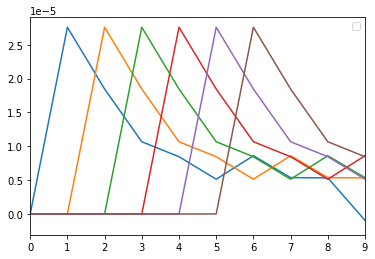

<Figure size 432x288 with 0 Axes>

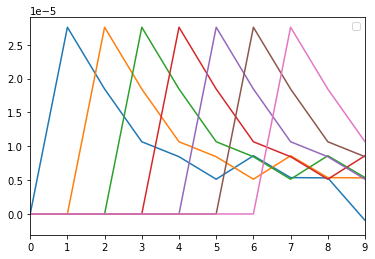

<Figure size 432x288 with 0 Axes>

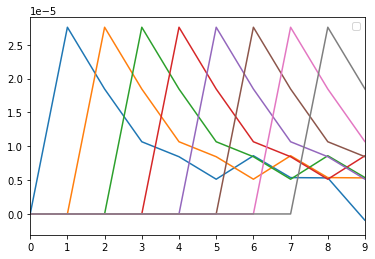

<Figure size 432x288 with 0 Axes>

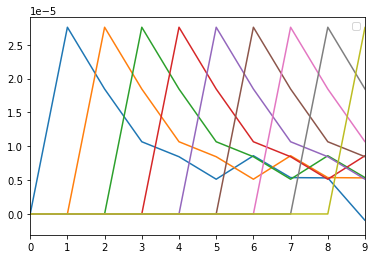

In [49]:
for n in np.arange(1,10):
    plt.figure()
    C_df[C_df.columns[:n]].plot()
    #plt.axvline(15)
    plt.xlim(0,9)
    plt.legend('')
    plt.savefig(f'video_images/000{n}.png')

<Figure size 432x288 with 0 Axes>

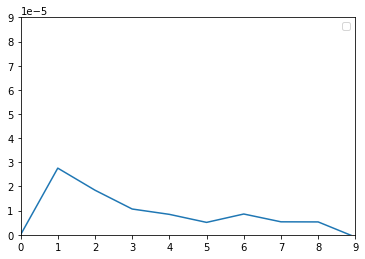

<Figure size 432x288 with 0 Axes>

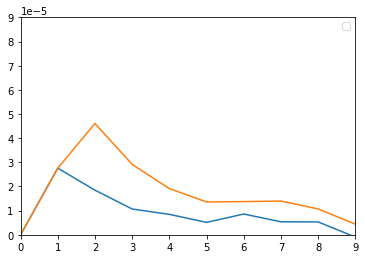

<Figure size 432x288 with 0 Axes>

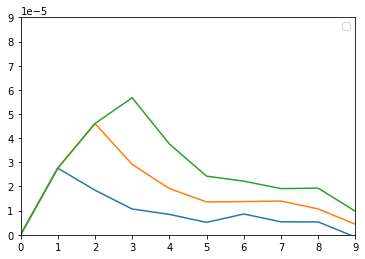

<Figure size 432x288 with 0 Axes>

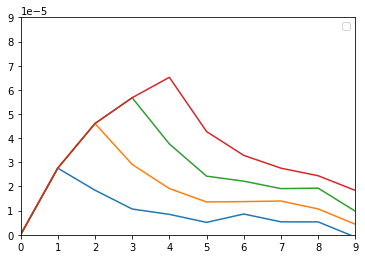

<Figure size 432x288 with 0 Axes>

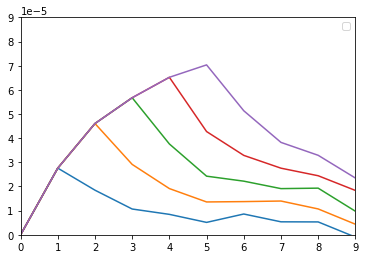

<Figure size 432x288 with 0 Axes>

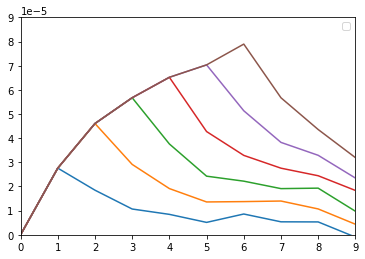

<Figure size 432x288 with 0 Axes>

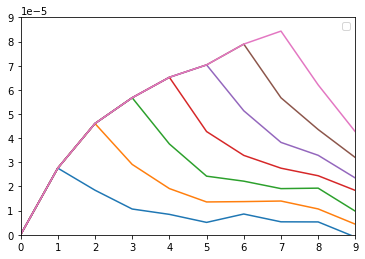

<Figure size 432x288 with 0 Axes>

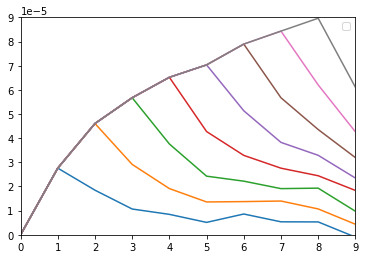

<Figure size 432x288 with 0 Axes>

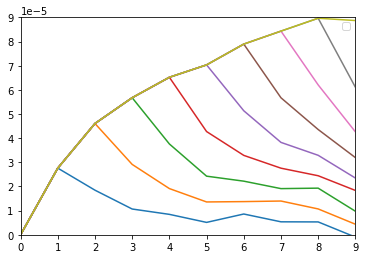

In [19]:
for n in np.arange(1,10):
    plt.figure()
    C_df.cumsum(axis = 1)[C_df.cumsum(axis = 1).columns[:n]].plot()
    #plt.axvline(15)
    plt.xlim(0,9)
    plt.ylim(0,9e-5)
    plt.legend('')
    plt.savefig(f'video_images/000{n}.png')

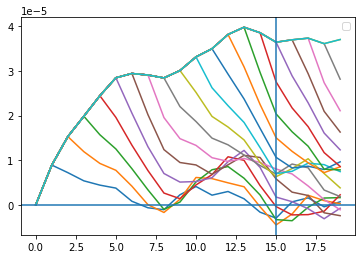

In [25]:
C_df.cumsum(axis = 1).plot()

plt.legend('')